In [11]:

cheapest_history: list[tuple[list[int], list[list[int]], int]] = []
from tsp.core.tsp import TSP
from tsp.core.solvers import pyramid_solve      # you can keep this import if you still need pyramid elsewhere
from tsp.experiment.batch_solver import solve_batch
from tsp.experiment.batch import save_problem_batch
import numpy.random as random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import json

# 1) generate & save one random TSP problem
cities = TSP.generate_random(50, w=500, h=500)
save_problem_batch([cities], 'pyramid_test/problems')

# (optional) your existing pyramid‐solve batch call
def pyramid_solve_2_4(problem):
    return pyramid_solve(problem, k=3, s=2)
solve_batch('pyramid_test/problems', pyramid_solve_2_4, 'pyramid_test/pyr_solutions')

# 2) load it back in
def load_tsp_coords(fp):
    with open(fp,'r') as f:
        return np.array(json.load(f)["cities"])

coords = load_tsp_coords("pyramid_test/problems/001.tsp")
num_cities = coords.shape[0]
print("Coords shape:", coords.shape)

tsp_problem = TSP.from_cities(coords, w=500, h=500)
centroids = [ np.array(pt, dtype=float) for pt in coords ]
nodes     = list(range(len(coords)))
# 3) helper to compute tour length from coords
def tour_length(tour: list[int]) -> float:
    idxs   = tour + [tour[0]]
    pts    = coords[idxs]
    deltas = pts[1:] - pts[:-1]
    return np.hypot(deltas[:,0], deltas[:,1]).sum()

# 4) define & record cheapest‐insertion
history = []  
'''def _cheapest_insertion_recorded(
    centroids: list[np.ndarray],
    nodes: list[int],
    prev_centroid: np.ndarray|None,
    next_centroid: np.ndarray|None
) -> list[int]:
    """
    Exactly the same as your _cheapest_insertion, but logs each insertion step
    into cheapest_history.
    """
    # start with the un‐visited nodes in the order given
    tour = list(nodes)
    # if you want to start with just two, you could do:
    # tour = [nodes[0], nodes[1]]
    # but here we’ll build up from scratch:
    while True:
        # build all possible one‐city insertions
        cands: list[tuple[list[int], float]] = []
        for i in range(len(tour)+1):
            for city in nodes:
                if city in tour: 
                    continue
                candidate = tour[:i] + [city] + tour[i:]
                # compute its closed‐loop length:
                pts = []
                if prev_centroid is not None:
                    pts.append(prev_centroid)
                pts += [centroids[j] for j in candidate]
                if next_centroid is not None:
                    pts.append(next_centroid)
                else:
                    pts.append(pts[0])
                dist = 0.0
                for a,b in zip(pts, pts[1:]):
                    dist += np.linalg.norm(a - b)
                cands.append((candidate, dist))

        if not cands:
            break

        # pick the best
        cands.sort(key=lambda x: x[1])
        candidate_tours = [cand for cand,_ in cands]
        best_idx = 0

        # RECORD the step:
        cheapest_history.append((tour.copy(), candidate_tours, best_idx))

        # now grow the tour:
        tour = candidate_tours[best_idx]

        # stop when you've inserted *all* nodes
        if set(tour) == set(nodes):
            break

    return tour'''
def _cheapest_insertion_recorded(
    centroids: list[np.ndarray],
    nodes:     list[int],
    prev_centroid: np.ndarray|None,
    next_centroid: np.ndarray|None
) -> list[int]:
    # 1) start with just two cities, e.g. [0,1]
    tour = [nodes[0], nodes[1]]

    # 2) keep going until every node is in tour
    while len(tour) < len(nodes):
        cands = []
        # only consider cities *not* yet in the tour
        for i in range(len(tour)+1):
            for city in nodes:
                if city in tour:
                    continue
                candidate = tour[:i] + [city] + tour[i:]
                # compute its loop‐length exactly as before …
                pts = []
                if prev_centroid is not None:
                    pts.append(prev_centroid)
                pts += [centroids[j] for j in candidate]
                if next_centroid is not None:
                    pts.append(next_centroid)
                else:
                    pts.append(pts[0])
                dist = 0.0
                for a,b in zip(pts, pts[1:]):
                    dist += np.linalg.norm(a-b)
                cands.append((candidate, dist))

        # pick best and record
        cands.sort(key=lambda x: x[1])
        candidate_tours = [cand for cand,_ in cands]
        best_idx = 0
        cheapest_history.append((tour.copy(), candidate_tours, best_idx))

        # update for next iteration
        tour = candidate_tours[best_idx]

    return tour


# 5) actually run it
cheapest_history.clear()
final_tour = _cheapest_insertion_recorded(centroids, nodes, prev_centroid=None, next_centroid=None)
print("Recorded steps:", len(cheapest_history))



Coords shape: (50, 2)
Recorded steps: 48


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
plt.rcParams['animation.html'] = 'jshtml'
tour_coords = coords[tour + [tour[0]]]
fig, ax = plt.subplots(figsize=(6, 6))
line, = ax.plot([], [], 'k-', lw=2)
points = ax.plot(coords[:, 0], coords[:, 1], 'ro')[0]

ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.set_title("Animated Pyramid Tour")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
ax.set_aspect('equal')

def init():
    line.set_data([], [])
    return line, points

def update(frame):
    x = tour_coords[:frame+1, 0]
    y = tour_coords[:frame+1, 1]
    line.set_data(x, y)
    return line, points
from IPython.display import HTML

ani = animation.FuncAnimation(
    fig, update, frames=len(tour_coords), init_func=init,
    interval=120, blit=True, repeat=False
)
HTML(ani.to_jshtml())
plt.show()
ani.save("pyramid_tour1.gif", writer="pillow", fps=10)



ValueError: max() iterable argument is empty

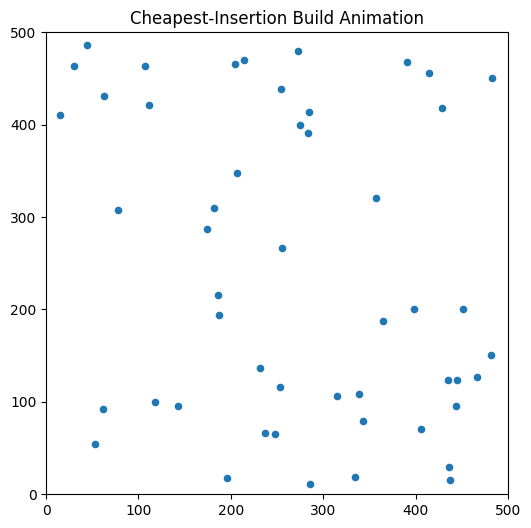

In [ ]:
# ─── Cell B: Animate the build process ────────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Precompute XY‐loops for each step
all_cand_xy = []
chosen_xy   = []
for partial, cands, best_idx in cheapest_history:
    # coords for every candidate, closed loop
    cand_loops = [ coords[c + [c[0]]] for c in cands ]
    all_cand_xy.append(cand_loops)
    # coords for the chosen one
    chosen   = cands[best_idx] + [cands[best_idx][0]]
    chosen_xy.append(coords[chosen])

# prepare figure
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(coords[:,0], coords[:,1], s=20)
ax.set(xlim=(0,500), ylim=(0,500), aspect="equal",
       title="Cheapest‑Insertion Build Animation")

# create blank Line2D objects
max_cands = max(len(c) for c in all_cand_xy)
gray_lines = [ ax.plot([], [], lw=1, color="lightgray")[0]
               for _ in range(max_cands) ]
red_line   = ax.plot([], [], lw=2, color="red")[0]

def init():
    for ln in gray_lines: ln.set_data([], [])
    red_line.set_data([], [])
    return gray_lines + [red_line]

def update(i):
    # draw all candidate tours in gray
    for ln, xy in zip(gray_lines, all_cand_xy[i]):
        ln.set_data(xy[:,0], xy[:,1])
    # clear any leftover lines
    for ln in gray_lines[len(all_cand_xy[i]):]:
        ln.set_data([], [])
    # draw chosen tour in red
    xy = chosen_xy[i]
    red_line.set_data(xy[:,0], xy[:,1])
    return gray_lines + [red_line]

ani = animation.FuncAnimation(
    fig, update, frames=len(cheapest_history),
    init_func=init, interval=300, blit=True, repeat=False
)

# render inline
HTML(ani.to_jshtml())

# optionally save to GIF
ani.save("cheapest_insertion.gif", writer="pillow", fps=4)
